In [2]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import keras

In [3]:
data = pickle.load(open("kneemridataset/329637-8.pck", 'rb'))
print(data.shape)

# Reorder from (depth, height, width) to (height, width, depth)
data = data.astype(np.float32)
modified_data = np.transpose(data, (1, 2, 0))

print(type(data))

(32, 320, 320)
<class 'numpy.ndarray'>


float32
0.0 1400.0


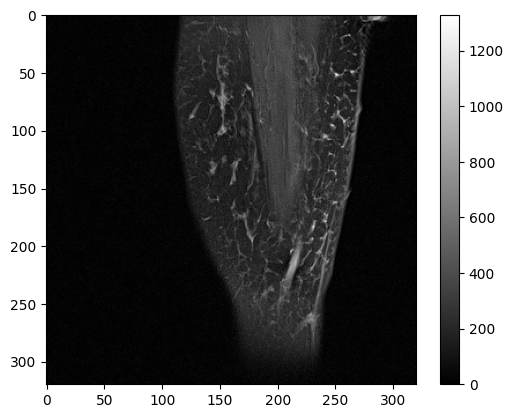

In [4]:

print(modified_data.dtype)
plt.imshow(modified_data[:,:,31], cmap='gray')  
cbar = plt.colorbar()
vmin, vmax = cbar.get_ticks()[0], cbar.get_ticks()[-1]
print (vmin, vmax)


In [5]:
import random

from scipy import ndimage
import numpy as np

from scipy import ndimage
def read_pickle_files(filepath):
    scan = pickle.load(open(str(filepath),'rb'))
    scan = scan.astype(np.float32)
    modified_data = np.transpose(scan, (1, 2, 0))
    return modified_data

def normalize(volume):
    """Normalize the volume"""
    min = 0
    max = 2007
    volume[volume < min] = min         # Clipping values below 0
    volume[volume > max] = max         # Clipping values above 2007
    volume = (volume - min) / (max - min)  # Scale to [0, 1]
    volume = volume.astype("float32")      # Convert to float32 for ML use
    return volume


def resize_volume(img, desired_depth=32, desired_height=320, desired_width=320):
    """Resize 3D volume to (desired_depth, desired_height, desired_width)"""
    
    # Original dimensions
    current_depth = img.shape[0]
    current_height = img.shape[1]
    current_width = img.shape[2]
    
    # Compute scaling factors
    depth_factor = desired_depth / current_depth
    height_factor = desired_height / current_height
    width_factor = desired_width / current_width
    
    # Resize using linear interpolation
    img = ndimage.zoom(img, (depth_factor, height_factor, width_factor), order=1)
    
    return img.astype(np.float32)


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_pickle_files(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume 



In [6]:
import os
import pandas as pd

# Load the metadata
csv_path = "kneemridataset/metadata.csv"
df = pd.read_csv(csv_path)

# Initialize lists for each diagnosis type
healthy_scans = []
partial_rupture_scans = []
full_rupture_scans = []

# Loop through each row
for index, row in df.iterrows():
    file_name = row["volumeFilename"]
    diagnosis = row["aclDiagnosis"]
    full_path = os.path.abspath(f"kneemridataset/{file_name}")

    if os.path.exists(full_path):
        if diagnosis == 0:
            healthy_scans.append(full_path)
        elif diagnosis == 1:
            partial_rupture_scans.append(full_path)
        elif diagnosis == 2:
            full_rupture_scans.append(full_path)

# Print results
print("Healthy scans:", len(healthy_scans), "->", healthy_scans[:3])
print("Partial rupture scans:", len(partial_rupture_scans), "->", partial_rupture_scans[:3])
print("Full rupture scans:", len(full_rupture_scans), "->", full_rupture_scans[:3])

print("total scans: ", len(healthy_scans)+ len(partial_rupture_scans)+len(full_rupture_scans))



Healthy scans: 546 -> ['/Users/abhishekpatawari/Desktop/project/acl_detection/kneemridataset/329637-8.pck', '/Users/abhishekpatawari/Desktop/project/acl_detection/kneemridataset/390116-9.pck', '/Users/abhishekpatawari/Desktop/project/acl_detection/kneemridataset/406320-9.pck']
Partial rupture scans: 144 -> ['/Users/abhishekpatawari/Desktop/project/acl_detection/kneemridataset/404663-8.pck', '/Users/abhishekpatawari/Desktop/project/acl_detection/kneemridataset/412865-8.pck', '/Users/abhishekpatawari/Desktop/project/acl_detection/kneemridataset/451760-9.pck']
Full rupture scans: 45 -> ['/Users/abhishekpatawari/Desktop/project/acl_detection/kneemridataset/463773-8.pck', '/Users/abhishekpatawari/Desktop/project/acl_detection/kneemridataset/472130-8.pck', '/Users/abhishekpatawari/Desktop/project/acl_detection/kneemridataset/476260-7.pck']
total scans:  735


In [7]:
# Ensure CELL INDEX 4 is executed before running this cell, as it defines the `process_scan` function.
import numpy as np

full_rupture = np.array([process_scan(path) for path in full_rupture_scans])
partial_rupture = np.array([process_scan(path) for path in partial_rupture_scans])
healthy = np.array([process_scan(path) for path in healthy_scans])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
full_rupture_labels = np.array([2 for _ in range(len(full_rupture))])
partial_rupture_labels = np.array([0 for _ in range(len(partial_rupture))])
healthy_labels = np.array([0 for _ in range(len(healthy))])

x_train = np.concatenate((healthy[:483], partial_rupture[:120],full_rupture[:38]), axis=0)
y_train = np.concatenate((healthy_labels[:483], partial_rupture_labels[:120],full_rupture_labels[:38]), axis=0)
x_val = np.concatenate((healthy[483:], partial_rupture[120:],full_rupture[38:]), axis=0)
y_val = np.concatenate((healthy_labels[483:], partial_rupture_labels[120:], full_rupture_labels[38:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 641 and 94.


In [8]:
import random
import tensorflow as tf
from scipy import ndimage


def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

: 

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

